<a href="https://colab.research.google.com/github/Thikkar/music-generator/blob/main/MusicGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Set-up

1.1 Scripts

In [15]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
! mkdir  ~/.kaggle

In [17]:
! cp kaggle.json ~/.kaggle/

In [18]:
! chmod 600 ~/.kaggle/kaggle.json

In [19]:
! kaggle datasets download -d michaelarman/poemsdataset

 32% 5.00M/15.5M [00:00<00:00, 34.6MB/s]
100% 15.5M/15.5M [00:00<00:00, 67.3MB/s]


In [20]:
! unzip poemsdataset.zip > out.txt

error:  cannot create topics/racism/RacismPoemsTranslationOfRacismIsAroundMeEverywhereByFrancisDugganржЖржорж░ржЪрж░ржкрж╢ржЫрзЬрзЯржЖржЫржЬрждржмржжржмрж╖ржорж▓ржлрж░ржирж╕рж╕ржбржЧржиPoembyAlamSayed.txt
        File name too long


1.2 Imports

In [61]:
import pandas as pd
import numpy as np
import os
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## 2. Data Pre-processing

2.1 Load Data

In [22]:
# Load data into pandas dataframe - [1 sec]
data = []

for root, dirs, files in os.walk("/content/topics"):
    label = os.path.basename(root)
    
    for file in files:
      path = root + '/' + file
      poem = []
      with open(path) as f:
        poem = f.readlines()

      poem_text = ''.join(poem)
      pair = (poem_text, label)
      data.append(pair)

poems_df = pd.DataFrame(data, columns=['poem', 'label'])
poems_df

,poem,label
0,Pay respect to\nYour Father\nYour Mother\nTo y...,respect
1,"Is a valued virtue,\nPriceless than any treasu...",respect
2,If You respect yourself respect to others you'...,respect
3,I am sitting in the back of the bus\nObserving...,respect
4,Respect another's wife\nAs your own mother\nTr...,respect
...,...,...
14329,"Something beautiful\nYou gave me,\nAlive and\n...",beautiful
14330,You are beautiful\nYour love shines right thro...,beautiful
14331,If you see me roaming Woodward Avenue\nDown by...,beautiful
14332,Crazy Loneliness Hijacks Memory of a Beautiful...,beautiful


2.2 Text Cleaning and Simplification

In [24]:
# Text cleaning (Lemmatization, Stemming, Stop Words, Punctuation) - [10 mins]
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

# https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# https://github.com/miguelfzafra/Latest-News-Classifier/blob/master/0.%20Latest%20News%20Classifier/03.%20Feature%20Engineering/03.%20Feature%20Engineering.ipynb
poems_classifier_df = poems_df
for idx in range(len(poems_classifier_df.poem)): 
    poem_clean = poems_classifier_df.poem[idx]

    poem_clean = re.split('\W+', poem_clean.lower())
    poem_clean = [w for w in poem_clean if not w in set(stopwords.words('english'))]  # Remove stopwords
    
    lem = WordNetLemmatizer()
    poem_clean = [lem.lemmatize(w, get_wordnet_pos(w)) for w in poem_clean if len(w) > 1]
    
    poem_clean = ' '.join(poem_clean)
    poems_classifier_df.poem[idx] = poem_clean

poems_classifier_df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


,poem,label
0,pay respect father mother guide philosopher re...,respect
1,value virtue priceless treasure sell bought gold,respect
2,respect respect others show never judge person...,respect
3,sit back bus observe child play weather gorgeo...,respect
4,respect another wife mother treat another poss...,respect
...,...,...
14329,something beautiful give alive need care thoug...,beautiful
14330,beautiful love shine right every time hear nam...,beautiful
14331,see roam woodward avenue majestic theater hum ...,beautiful
14332,crazy loneliness hijack memory beautiful girl ...,beautiful


In [72]:
# Re-map each label

categories_dictionary = {
  "alone": "sad",
  "america": "location",
  "angel": "religious",
  "anger": "evil",
  "animal": "animal",
  "baby": "family",
  "beach": "nature",
  "beautiful": "love",
  "beauty": "love",
  "believe": "inspirational",
  "birth": "family",
  "brother": "family",
  "butterfly": "animal",
  "car": "object",
  "carpe diem": "inspirational",
  "change": "unknown",
  "chicago": "location",
  "childhood": "family",
  "children": "family",
  "christmas": "religious",
  "cinderella": "unknown",
  "city": "location",
  "courage": "inspirational",
  "crazy": "evil",
  "culture": "unknown",
  "dance": "activity",
  "dark": "sad",
  "daughter": "family",
  "death": "sad",
  "depression": "sad",
  "despair": "sad",
  "destiny": "inspirational",
  "dream": "inspirational",
  "evil": "evil",
  "faith": "religious",
  "family": "family",
  "father": "family",
  "fear": "evil",
  "fire": "nature",
  "food": "object",
  "football": "object",
  "freedom": "inspirational",
  "friend": "family",
  "frog": "animal",
  "funeral": "sad",
  "funny": "happy",
  "future": "unknown",
  "girl": "unknown",
  "god": "religious",
  "graduation": "unknown",
  "greed": "evil",
  "green": "object",
  "hair": "object",
  "happiness": "happy",
  "happy": "happy",
  "hate": "evil",
  "heaven": "religious",
  "hero": "inspirational",
  "home": "family",
  "hope": "inspirational",
  "house": "family",
  "hunting": "activity",
  "husband": "family",
  "identity": "unknown",
  "innocence": "unknown",
  "january": "unknown",
  "joy": "happy",
  "june": "unknown",
  "justice": "inspirational",
  "kiss": "love",
  "laughter": "happy",
  "life": "introspection",
  "lonely": "sad",
  "loss": "sad",
  "lost": "sad",
  "love": "love",
  "lust": "evil",
  "marriage": "love",
  "memory": "introspection",
  "mirror": "object",
  "money": "object",
  "moon": "object",
  "mother": "family",
  "murder": "evil",
  "music": "unknown",
  "nature": "nature",
  "night": "nature",
  "ocean": "nature",
  "paris": "location",
  "passion": "love",
  "peace": "happy",
  "pink": "object",
  "poem": "unknown",
  "poetry": "unknown",
  "poverty": "sad",
  "power": "unknown",
  "racism": "unknown",
  "rain": "nature",
  "rainbow": "nature",
  "red": "object",
  "remember": "introspection",
  "respect": "love",
  "river": "nature",
  "romance": "love",
  "romantic": "love",
  "rose": "nature",
  "running": "activity",
  "school": "activity",
  "sea": "nature",
  "sick": "sad",
  "silver": "object",
  "sister": "family",
  "sky": "nature",
  "sleep": "activity",
  "snake": "nature",
  "soldier": "unknown",
  "sometimes": "unknown",
  "son": "family",
  "song": "unknown",
  "sorrow": "sad",
  "spring": "nature",
  "star": "nature",
  "success": "inspirational",
  "suicide": "sad",
  "summer": "nature",
  "sun": "nature",
  "swimming": "activity",
  "sympathy": "sad",
  "teacher": "activity",
  "thanks": "happy",
  "time": "introspection",
  "today": "unknown",
  "together": "love",
  "travel": "activity",
  "trust": "love",
  "truth": "unknown",
  "unknown": "unknown",
  "war": "evil",
  "warning": "evil",
  "water": "nature",
  "weather": "nature",
  "wedding": "love",
  "winter": "nature",
  "work": "activity",
  "world": "nature",
}

In [34]:
# Replace labels
for idx, label in enumerate(poems_classifier_df.label):
  if label in categories_dictionary:
    poems_classifier_df.label[idx] = categories_dictionary[label]

# Drop miscellaneous poems
drop_labels = ["unknown", "object", "animal", "location", "religious", "introspection"]
for label in drop_labels:
  poems_classifier_df = poems_classifier_df[poems_classifier_df.label != label]

poems_classifier_df

,poem,label
0,pay respect father mother guide philosopher re...,love
1,value virtue priceless treasure sell bought gold,love
2,respect respect others show never judge person...,love
3,sit back bus observe child play weather gorgeo...,love
4,respect another wife mother treat another poss...,love
...,...,...
14329,something beautiful give alive need care thoug...,love
14330,beautiful love shine right every time hear nam...,love
14331,see roam woodward avenue majestic theater hum ...,love
14332,crazy loneliness hijack memory beautiful girl ...,love


2.3 EDA

Text(0.5, 1.0, 'Frequency Distribution of Labels')

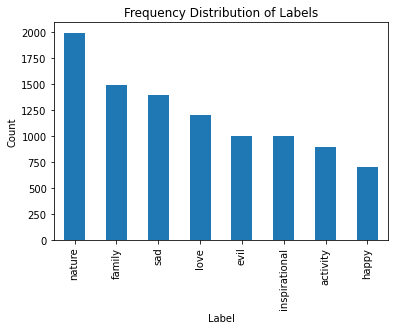

In [36]:
# Frequency Distribution of labels

fig, ax = plt.subplots()
poems_classifier_df['label'].value_counts().plot(ax=ax, kind='bar')
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Frequency Distribution of Labels")

2.4 Input/Output Encoding

In [63]:
# Label Encoder - [1 sec]
enc = LabelEncoder()
poems_classifier_df["label_encoded"] = enc.fit_transform( poems_classifier_df["label"] )

# TF-IDF - [2 sec]
X, y = poems_classifier_df["poem"].values, poems_classifier_df["label_encoded"].values

vectorizer = TfidfVectorizer(max_features=5000)
X_vectorized = vectorizer.fit_transform(X).toarray()

poems_classifier_df

,poem,label,label_encoded
0,pay respect father mother guide philosopher re...,love,5
1,value virtue priceless treasure sell bought gold,love,5
2,respect respect others show never judge person...,love,5
3,sit back bus observe child play weather gorgeo...,love,5
4,respect another wife mother treat another poss...,love,5
...,...,...,...
14329,something beautiful give alive need care thoug...,love,5
14330,beautiful love shine right every time hear nam...,love,5
14331,see roam woodward avenue majestic theater hum ...,love,5
14332,crazy loneliness hijack memory beautiful girl ...,love,5


2.5 Train/Test Split

In [71]:
# Train/Test Split - [3 sec]
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, stratify=y)

## 3. Model(s)

In [ ]:
## Neural Network

## 4. Notes

In [ ]:
with open("/content/topics/marriage/MarriagePoemsMarriageSongPoembyYehudahHaLevi.txt") as f:
  lines = f.readlines()

print(lines)

['Fair is my dove, my loved one,\n', 'None can with her compare:\n', 'Yea, comely as Jerusalem,\n', 'Like unto Tirzah fair.\n', 'Shall she in tents unstable\n', 'A wanderer abide,\n', 'While in my heart awaits her\n', 'A dwelling deep and wide?\n', 'The magic of her beauty\n', 'Has stolen my heart away:\n', "Not Egypt's wise enchanters\n", 'Held half such wondrous sway.\n', 'Even as the changing opal\n', 'In varying luster glows,\n', 'Her face at every moment\n', 'New charms and sweetness shows.\n', 'White lilies and red roses\n', 'There blossom on one stem:\n', 'Her lips of crimson berries\n', 'Tempt mine to gather them.\n', 'By dusky tresses shaded\n', 'Her brow gleams fair and pale,\n', 'Like to the sun at twilight,\n', 'Behind a cloudy veil.\n', 'Her beauty shames the day-star,\n', 'And makes the darkness light:\n', 'Day in her radiant presence\n', 'Grows seven times more bright.\n', 'This is a lonely lover!\n', 'Come, fair one, to his side,\n', 'That happy be together\n', 'The bri

In [ ]:
# This is a sentence ->{'<s>', 'This', 'is', 'a', 'sentence', '</s>'}

# corpus: body of text (pl. corpora)
# token: "word"